In [8]:
import matplotlib.pyplot as plt
import networkx as nx
import pandas as pd
import numpy as np
import requests
import json

def pass_web_directed(team, ssn, web, show_frac=0.3):

    ### the 'team' parameter takes in an nba team's three letter abbreviation. 'GSW' for the golden state warriors, for example
    ### the 'ssn' parameter takes in an nba season (2013-14 at the earliest). '2015-16' for example
    ### the 'web' parameter takes in 'AST' or 'pass' (or other variations of the two).
    ### the 'web' parameter exists because you can create networks in which the lines represent either assists or passes -- the parameter is used to tell which one of the two you'd like to do
    ### example of usage: pass_web('GSW','2016-17','AST')

    if (web in ['ast','AST','assist','assists','assisting','ASSIST','ASSISTS']):
        web = 'assist'
    elif (web in ['pass','passes','passing','PASS','PASSES']):
        web = 'pass'
    else:
        return print('Error: Third parameter requires "assist" or "pass" input')

    headers = {'Host': 'stats.nba.com','Accept': 'application/json, text/plain, */*','x-nba-stats-token': 'true','User-Agent': 'Mozilla/5.0 (Linux; Android 6.0; Nexus 5 Build/MRA58N) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/109.0.0.0 Mobile Safari/537.36','x-nba-stats-origin': 'stats','Origin': 'https://www.nba.com','Referer': 'https://www.nba.com/','Accept-Encoding': 'gzip, deflate, br','Accept-Language': 'en-US,en;q=0.9}'}
    ### scrape stats.nba.com to find the team_id for the inputted team
    print("Retrieving from NBA Stats URL...")
    url = 'https://stats.nba.com/stats/leaguedashptstats?College=&Conference=&Country=&DateFrom=&DateTo=&Division=&DraftPick=&DraftYear=&GameScope=&GameSegment=&Height=&LastNGames=0&LeagueID=00&Location=&Month=0&OpponentTeamID=0&Outcome=&PORound=0&PerMode=PerGame&Period=0&PlayerExperience=&PlayerOrTeam=Team&PlayerPosition=&PtMeasureType=Drives&Season=' + str(ssn) + '&SeasonSegment=&SeasonType=Regular+Season&StarterBench=&TeamID=0&VsConference=&VsDivision=&Weight='

    json = requests.get(url, headers=headers).json()
    print("Data retrieved...")
    data = json['resultSets'][0]['rowSet']
    columns = json['resultSets'][0]['headers']

    tms = pd.DataFrame.from_records(data, columns=columns)
    team_id = tms[tms.TEAM_ABBREVIATION == team].reset_index(drop=True).TEAM_ID[0]
    team_name = tms[tms.TEAM_ABBREVIATION == team].reset_index(drop=True).TEAM_NAME[0]

    ### using the scraped team_id, find all players who accumulated at least 10 assists with that team in the inputted season

    url = 'https://stats.nba.com/stats/leaguedashplayerstats?College=&Conference=&Country=&DateFrom=&DateTo=&Division=&DraftPick=&DraftYear=&GameScope=&GameSegment=&Height=&LastNGames=0&LeagueID=00&Location=&MeasureType=Base&Month=0&OpponentTeamID=0&Outcome=&PORound=0&PaceAdjust=N&PerMode=Totals&Period=0&PlayerExperience=&PlayerPosition=&PlusMinus=N&Rank=N&Season=' + str(ssn) + '&SeasonSegment=&SeasonType=Regular+Season&ShotClockRange=&StarterBench=&TeamID=' + str(team_id) + '&TwoWay=0&VsConference=&VsDivision=&Weight='

    json = requests.get(url, headers=headers).json()

    data = json['resultSets'][0]['rowSet']
    columns = json['resultSets'][0]['headers']

    df = pd.DataFrame.from_records(data, columns=columns)

    df = df[df.AST > 10]

    players = df.PLAYER_ID.unique()

    ### using the players previously found, record all of their pass connections while on the team

    df_list = []

    for x in players:

        url = 'https://stats.nba.com/stats/playerdashptpass?DateFrom=&DateTo=&GameSegment=&LastNGames=0&LeagueID=00&Location=&Month=0&OpponentTeamID=0&Outcome=&PORound=0&PerMode=Totals&Period=0&PlayerID=' + str(x) + '&Season=' + str(ssn) + '&SeasonSegment=&SeasonType=Regular+Season&TeamID=0&VsConference=&VsDivision='

        json = requests.get(url, headers=headers).json()

        data = json['resultSets'][0]['rowSet']
        columns = json['resultSets'][0]['headers']

        df_list.append(pd.DataFrame.from_records(data, columns=columns))

    df = pd.concat(df_list)

    df = df[['TEAM_ABBREVIATION','PLAYER_NAME_LAST_FIRST','PASS_TO','PASS','AST']]
    df.columns = ['tm','passer','receiver','passes','ast']
    def fix_name(name):
        if ',' in name:
            return name.split(", ")[1][:1] + "." + name.split(", ")[0]
        else:
            return name
    df.passer = np.vectorize(fix_name)(df.passer)
    df.receiver = np.vectorize(fix_name)(df.receiver)
    # Filter DataFrame based on the team and season (simulated here as it's static data)
    df_filtered = df[(df['tm'] == team)]

    # Create a directed graph
    G = nx.DiGraph()

    # Add edges to the graph
    for _, row in df_filtered.iterrows():
        if web == "pass":
            G.add_edge(row['passer'], row['receiver'], weight=row['passes'])
        else:
            G.add_edge(row['passer'], row['receiver'], weight=row['ast'])

    # Filter edges to show only the top 50% based on the number of passes
    edges = [(u, v, d) for u, v, d in G.edges(data=True)]
    edges.sort(key=lambda x: x[2]['weight'], reverse=True)
    top_edges = edges[:len(edges) // int(1/show_frac)]

    # Create a subgraph with only the top 50% edges
    G_top = nx.DiGraph()
    G_top.add_edges_from((u, v, {'weight': d['weight']}) for u, v, d in top_edges)

    # Create a dictionary for node sizes
    if web == "pass":
        node_sizes_dict = df_filtered.groupby('passer')['passes'].sum().to_dict()
    else:
        node_sizes_dict = df_filtered.groupby('passer')['ast'].sum().to_dict()
    # Normalize node sizes for better visualization
    max_passes = max(node_sizes_dict.values())
    node_sizes = [0.01 if node_sizes_dict.get(node, 0) == 0 else (node_sizes_dict.get(node, 0) / max_passes) * 1000 for node in G_top.nodes()]

    # Draw the graph
    pos = nx.circular_layout(G_top)
    weights = [G_top[u][v]['weight'] for u, v in G_top.edges()]
    edge_widths = [weight / max(weights) * 5 for weight in weights]
    plt.figure(figsize=(8,8))

    nx.draw_circular(G_top, with_labels=True, node_size=node_sizes, linewidths=2, edge_color=weights, width=edge_widths, edge_cmap=plt.cm.binary, node_color='lightblue')

    # plt.savefig(f"{team}_{ssn}_{web}.svg", dpi=600, bbox_inches='tight')
    plt.show()




Retrieving from NBA Stats URL...
Data retrieved...


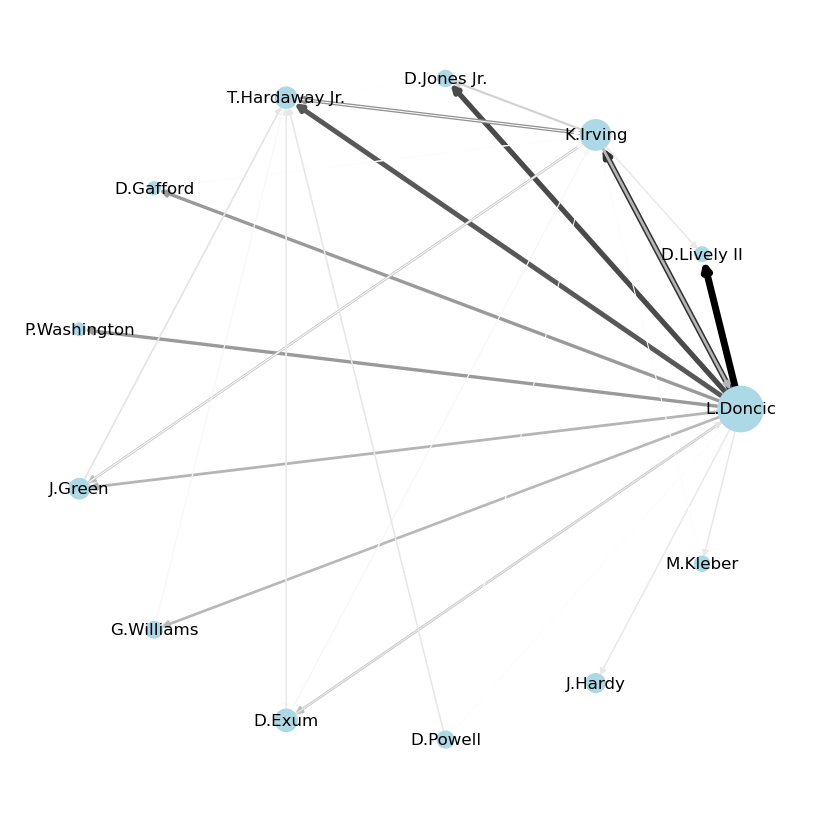

In [9]:
# Example call to the function
pass_web_directed('DAL', '2023-24', 'AST', show_frac=0.1)

Retrieving from NBA Stats URL...
Data retrieved...


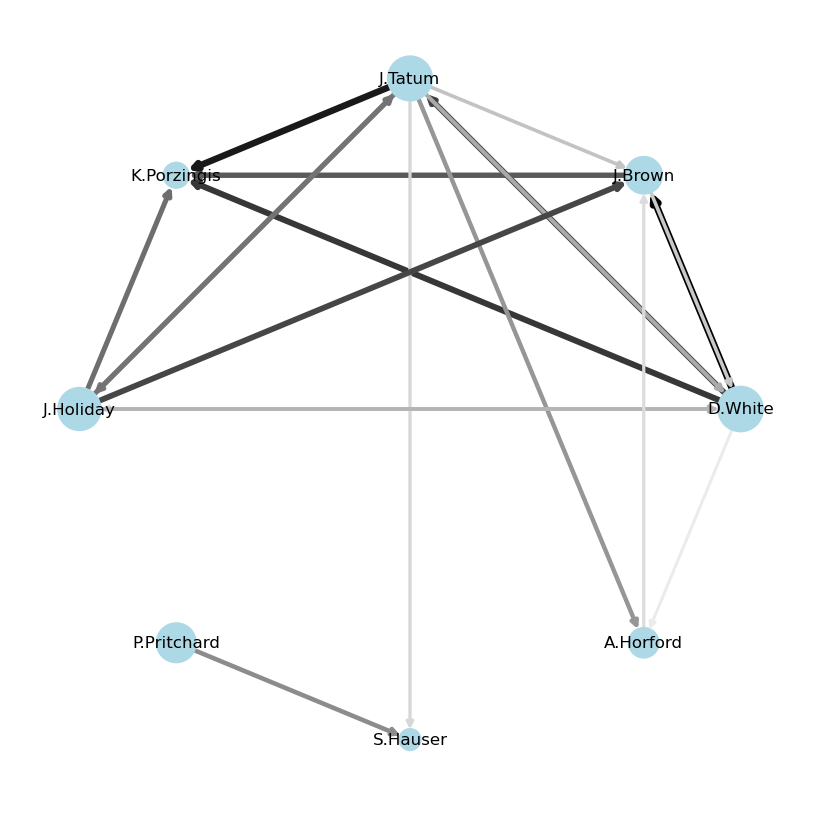

In [10]:
# Example call to the function
pass_web_directed('BOS', '2023-24', 'AST', show_frac=0.1)